In [1]:
!git clone https://github.com/jacopomangiavacchi/animegan2-pytorch

Cloning into 'animegan2-pytorch'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 184 (delta 89), reused 74 (delta 19), pack-reused 0
Receiving objects: 100% (184/184), 37.77 MiB | 30.15 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [7]:
import os
import cv2
import matplotlib.pyplot as plt
import torch
import random
import numpy as np

os.chdir(f'./animegan2-pytorch')

In [9]:
from model import Generator

def load_image(path, size=None):
    image = image2tensor(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))

    w, h = image.shape[-2:]
    if w != h:
        crop_size = min(w, h)
        left = (w - crop_size)//2
        right = left + crop_size
        top = (h - crop_size)//2
        bottom = top + crop_size
        image = image[:,:,left:right, top:bottom]

    if size is not None and image.shape[-1] != size:
        image = torch.nn.functional.interpolate(image, (size, size), mode="bilinear", align_corners=True)
    
    return image

def image2tensor(image):
    image = torch.FloatTensor(image).permute(2,0,1).unsqueeze(0)/255.
    return (image-0.5)/0.5

def tensor2image(tensor):
    tensor = tensor.clamp_(-1., 1.).detach().squeeze().permute(1,2,0).cpu().numpy()
    return tensor*0.5 + 0.5

def imshow(img, size=5, cmap='jet'):
    plt.figure(figsize=(size,size))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

In [13]:
device = 'cpu'
torch.set_grad_enabled(False)
image_size = 300 # Can be tuned, works best when the face width is between 200~250 px

model = Generator().eval().to(device)

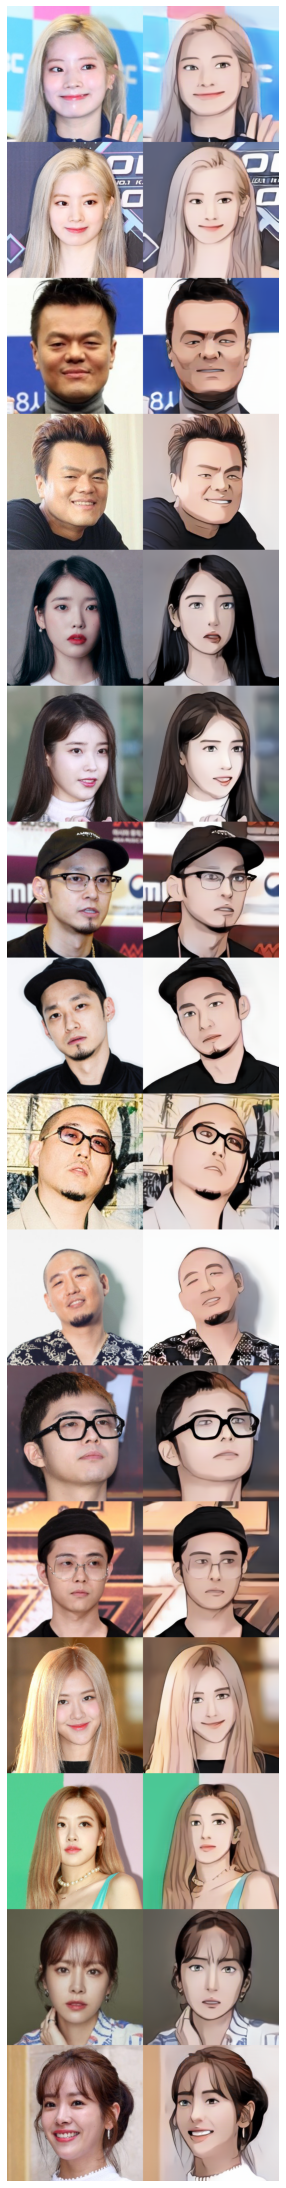

In [14]:
ckpt = torch.load(f"weights/celeba_distill.pt", map_location=device)
# ckpt = torch.load(f"weights/face_paint_512_v2.pt", map_location=device)
# ckpt = torch.load(f"weights/paprika.pt", map_location=device)
model.load_state_dict(ckpt)
    
results = []
for j in range(1,17):
    image = load_image(f"samples/faces/{j}.jpg", image_size)
    output = model(image.to(device))

    results.append(torch.cat([image, output.cpu()], 3))
results = torch.cat(results, 2)

imshow(tensor2image(results),40)
# cv2.imwrite('./samples/face_results.jpg', cv2.cvtColor(255*tensor2image(results), cv2.COLOR_BGR2RGB))

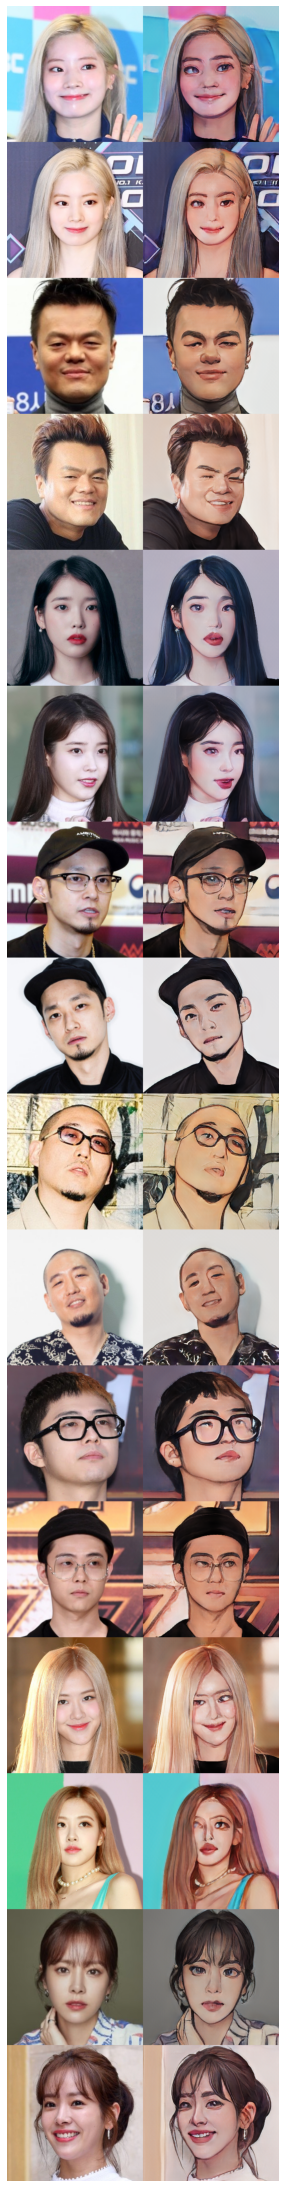

In [15]:
# ckpt = torch.load(f"weights/celeba_distill.pt", map_location=device)
ckpt = torch.load(f"weights/face_paint_512_v2.pt", map_location=device)
# ckpt = torch.load(f"weights/paprika.pt", map_location=device)
model.load_state_dict(ckpt)
    
results = []
for j in range(1,17):
    image = load_image(f"samples/faces/{j}.jpg", image_size)
    output = model(image.to(device))

    results.append(torch.cat([image, output.cpu()], 3))
results = torch.cat(results, 2)

imshow(tensor2image(results),40)
# cv2.imwrite('./samples/face_results.jpg', cv2.cvtColor(255*tensor2image(results), cv2.COLOR_BGR2RGB))

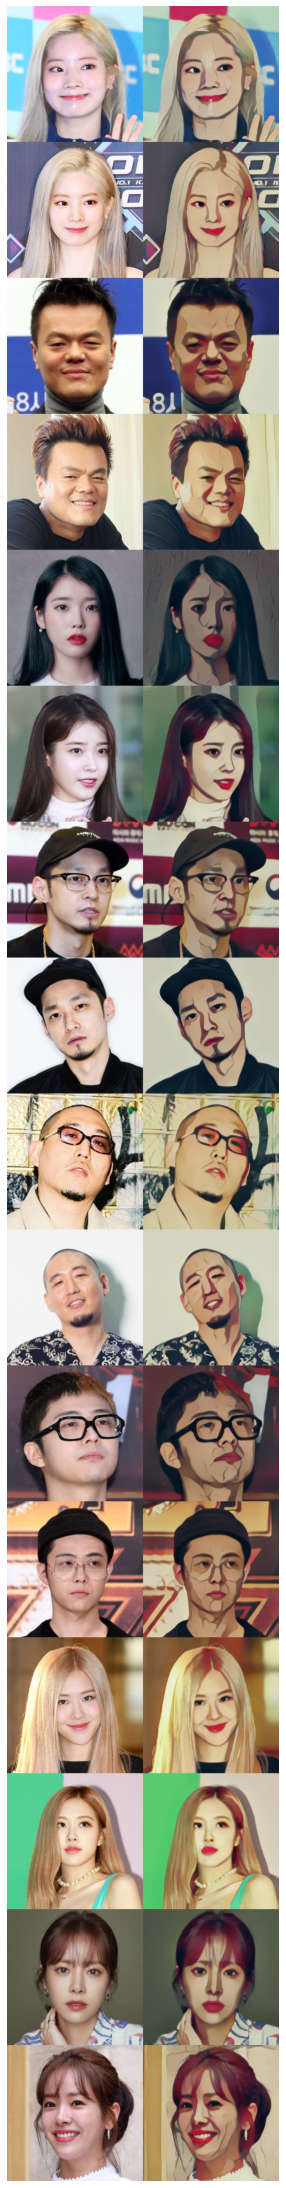

In [16]:
# ckpt = torch.load(f"weights/celeba_distill.pt", map_location=device)
# ckpt = torch.load(f"weights/face_paint_512_v2.pt", map_location=device)
ckpt = torch.load(f"weights/paprika.pt", map_location=device)
model.load_state_dict(ckpt)
    
results = []
for j in range(1,17):
    image = load_image(f"samples/faces/{j}.jpg", image_size)
    output = model(image.to(device))

    results.append(torch.cat([image, output.cpu()], 3))
results = torch.cat(results, 2)

imshow(tensor2image(results),40)
# cv2.imwrite('./samples/face_results.jpg', cv2.cvtColor(255*tensor2image(results), cv2.COLOR_BGR2RGB))